# Import the core packages
> Other dependencies will be imported based on need in the following code cells

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Data Preparation

import our dataset -- primary FAANG stock data which include AAPL, NETFLIX, GOOGL, MSFT, AMZN.
 This dataset has been pre-processed to remove **NaN** values.
 
 It could still have problems that could bias the outcome like errors in input, duplication, etc.

In [214]:
# import all the unclean data for aal five stocks into separate variables 
uDataAmazon = pd.read_csv('./data/Amazon.csv', index_col = False)
uDataApple = pd.read_csv('./data/Apple.csv')
uDataGoogle = pd.read_csv('./data/Google.csv')
uDataNetflix = pd.read_csv('./data/Netflix.csv')
uDataMicrosoft = pd.read_csv('./data/Microsoft.csv')

# combine all the temp data values into a list to perform mapping operations
uDataList = [ uDataAmazon, uDataApple, uDataGoogle, uDataMicrosoft, uDataNetflix ]

In [215]:
# view what the data looks like
uDataAmazon.head()

,Open,High,Low,Close,Adj Close,Volume,Date
0,4.075000,4.478125,3.952344,4.468750,4.468750,322352000,2000-01-03
1,4.268750,4.575000,4.087500,4.096875,4.096875,349748000,2000-01-04
2,3.525000,3.756250,3.400000,3.487500,3.487500,769148000,2000-01-05
3,3.565625,3.634375,3.200000,3.278125,3.278125,375040000,2000-01-06
4,3.350000,3.525000,3.309375,3.478125,3.478125,210108000,2000-01-07


In [216]:
# view a discription of the data 
uDataGoogle.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4677.000000,4677.000000,4677.000000,4677.000000,4677.000000,4.677000e+03
mean,38.255309,38.656113,37.861995,38.265822,38.265822,1.226090e+08
std,35.540477,35.943265,35.161971,35.555944,35.555944,1.529406e+08
min,2.470490,2.534002,2.390042,2.490913,2.490913,1.584340e+05
25%,12.657307,12.771629,12.487195,12.640869,12.640869,2.968400e+07
50%,25.577278,25.772150,25.253166,25.534290,25.534290,6.698614e+07
75%,54.528500,55.233501,53.894001,54.546501,54.546501,1.527946e+08
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.650833e+09


In [217]:
# view the information 
uDataAmazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5839 entries, 0 to 5838
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5839 non-null   float64
 1   High       5839 non-null   float64
 2   Low        5839 non-null   float64
 3   Close      5839 non-null   float64
 4   Adj Close  5839 non-null   float64
 5   Volume     5839 non-null   int64  
 6   Date       5839 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 319.4+ KB


In [218]:
# Check for NaN values in each column of each unclean dataset
nan_counts = [ list(data.isna().sum()) for data in uDataList ]
nan_counts

[[0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0]]

In [219]:
# duplicate data count detection in data 
duplicates_per_df = [ df.duplicated().sum() for df in uDataList ]
duplicates_per_df

[0, 0, 0, 0, 0]

# Visual of the complete data of all five datasets
This is done before splitting the data into training and testing sets to see and analyze correlation between stocks of the same category.
Correlation detection of closing prices and volume has to be correlated so that the model can work on the category instead of singe units.



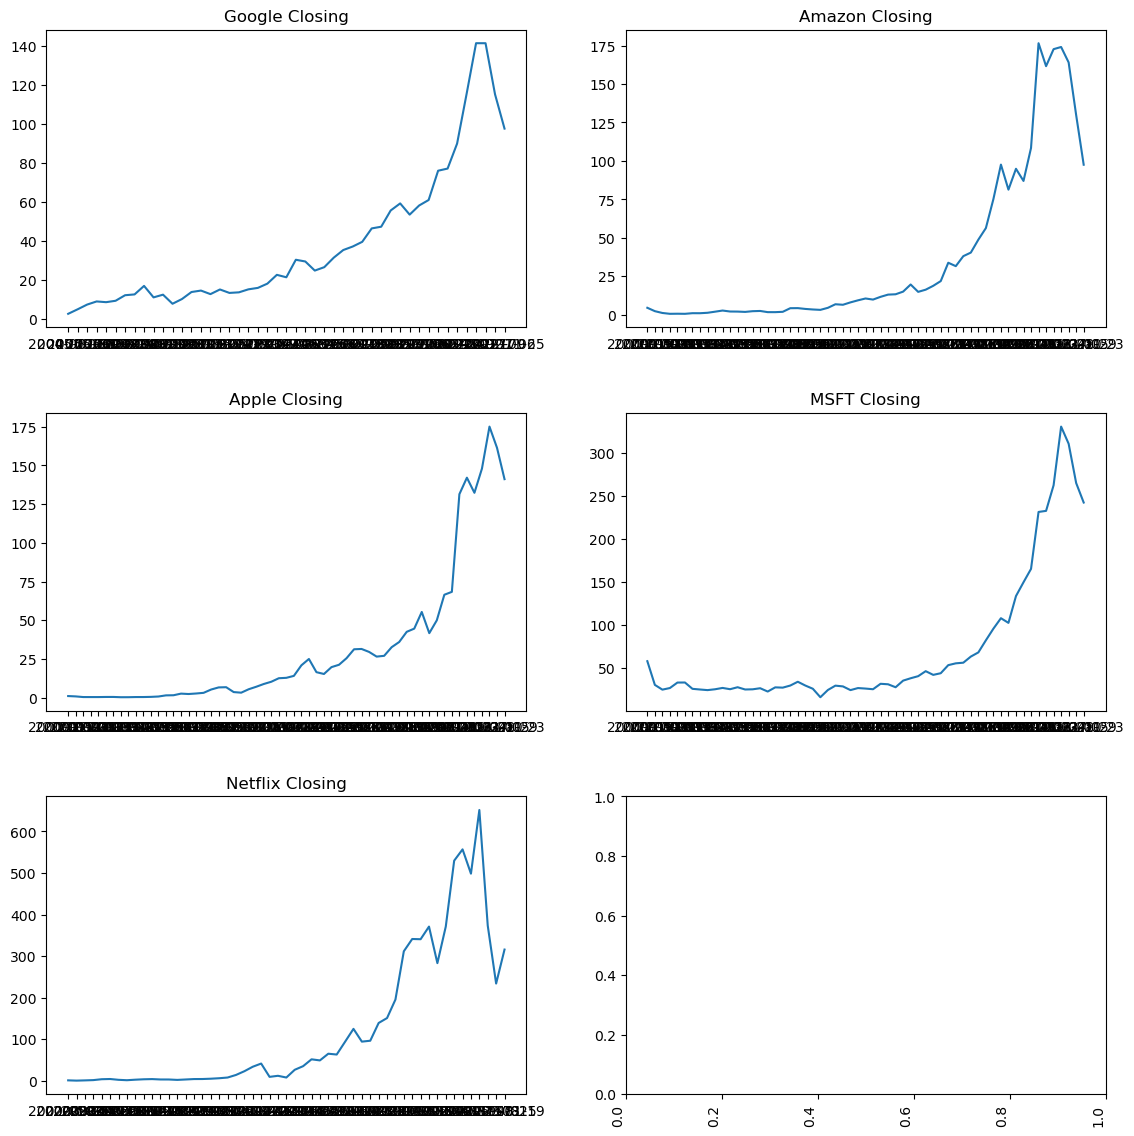

In [220]:
# Initialize the subplot function using the number of rows and columns
figure, axis = plt.subplots(3, 2, figsize=(12, 12))

# For Google's closing function (using a step of 100 to render it better)
axis[0, 0].plot(uDataGoogle['Date'][0:len(uDataGoogle):100], uDataGoogle['Close'][0:len(uDataGoogle):100])
axis[0, 0].set_title("Google Closing")

# For Amazon's closing function (using a step of 100 to render it better)
axis[0, 1].plot(uDataAmazon['Date'][0:len(uDataAmazon):100], uDataAmazon['Close'][0:len(uDataAmazon):100])
axis[0, 1].set_title("Amazon Closing")

# For Apple's closing function (using a step of 100 to render it better)
axis[1, 0].plot(uDataApple['Date'][0:len(uDataApple):100], uDataApple['Close'][0:len(uDataApple):100])
axis[1, 0].set_title("Apple Closing")

# For Microsoft's closing function (using a step of 100 to render it better)
axis[1, 1].plot(uDataMicrosoft['Date'][0:len(uDataMicrosoft):100], uDataMicrosoft['Close'][0:len(uDataMicrosoft):100])
axis[1, 1].set_title("MSFT Closing")

# For Netflix's closing function (using a step of 100 to render it better)
axis[2, 0].plot(uDataNetflix['Date'][0:len(uDataNetflix):100], uDataNetflix['Close'][0:len(uDataNetflix):100])
axis[2, 0].set_title("Netflix Closing")

# Adjust layout and rotation of x-axis labels
plt.xticks(rotation='vertical', ha='right')
plt.tight_layout(pad=3.0)

# Combine all the operations and display
plt.show()


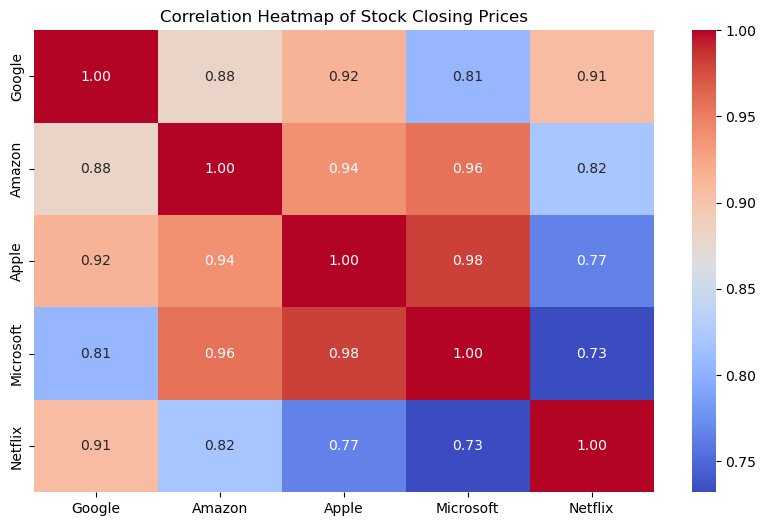

In [221]:
# Combine the data from all companies into a single DataFrame
combined_data = pd.concat([uDataGoogle['Close'], uDataAmazon['Close'], uDataApple['Close'], 
                           uDataMicrosoft['Close'], uDataNetflix['Close']], axis=1)
combined_data.columns = ['Google', 'Amazon', 'Apple', 'Microsoft', 'Netflix']

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(combined_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Stock Closing Prices')
plt.show()

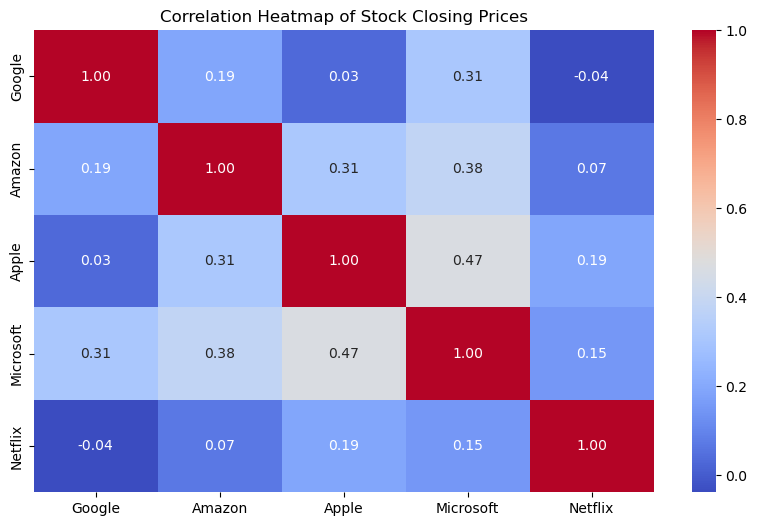

In [222]:
# Combine the data from all companies into a single DataFrame
combined_data = pd.concat([uDataGoogle['Volume'], uDataAmazon['Volume'], uDataApple['Volume'], 
                           uDataMicrosoft['Volume'], uDataNetflix['Volume']], axis=1)
combined_data.columns = ['Google', 'Amazon', 'Apple', 'Microsoft', 'Netflix']

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(combined_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Stock Closing Prices')
plt.show()

# Data Cleaning
> Cleaning will be done on amazon's data and then applied to other datasets later on

In [223]:
# copy the date col before setting it as index
uDataAmazon['date'] = uDataAmazon['Date'].copy()

# set the index column and substitue it with date column
uDataAmazon.set_index('Date', inplace=True)

In [224]:
uDataAmazon

,Open,High,Low,Close,Adj Close,Volume,date
Date,,,,,,,
2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000,2000-01-03
2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000,2000-01-04
2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000,2000-01-05
2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000,2000-01-06
2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000,2000-01-07
...,...,...,...,...,...,...,...
2023-03-13,89.970001,94.019997,88.120003,92.430000,92.430000,72397100,2023-03-13
2023-03-14,93.830002,95.070000,92.709999,94.879997,94.879997,60912700,2023-03-14
2023-03-15,93.220001,96.669998,93.070000,96.199997,96.199997,70731800,2023-03-15


In [225]:
uDataAmazon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5839 entries, 2000-01-03 to 2023-03-17
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5839 non-null   float64
 1   High       5839 non-null   float64
 2   Low        5839 non-null   float64
 3   Close      5839 non-null   float64
 4   Adj Close  5839 non-null   float64
 5   Volume     5839 non-null   int64  
 6   date       5839 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 364.9+ KB


In [226]:
# convert the type of 'Date' from object to DateTime
import datetime

def convert_to_datetime(date):
    temp = date.split('-')
    return datetime.datetime(year=int(temp[0]), month=int(temp[1]), day=int(temp[2]))


In [227]:
# apply this funtion the date col to convert its type
uDataAmazon['date'] = uDataAmazon['date'].apply(convert_to_datetime)
uDataAmazon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5839 entries, 2000-01-03 to 2023-03-17
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       5839 non-null   float64       
 1   High       5839 non-null   float64       
 2   Low        5839 non-null   float64       
 3   Close      5839 non-null   float64       
 4   Adj Close  5839 non-null   float64       
 5   Volume     5839 non-null   int64         
 6   date       5839 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 364.9+ KB


# Data Partitioning and Splits
> We're only using the close price of the selected df to make three separate features using the window method.
> 'date' will be the marker col

In [228]:
# clean data of amazon
cDataAmazon = uDataAmazon[['date', 'Close']]
cDataAmazon

,date,Close
Date,,
2000-01-03,2000-01-03,4.468750
2000-01-04,2000-01-04,4.096875
2000-01-05,2000-01-05,3.487500
2000-01-06,2000-01-06,3.278125
2000-01-07,2000-01-07,3.478125
...,...,...
2023-03-13,2023-03-13,92.430000
2023-03-14,2023-03-14,94.879997
2023-03-15,2023-03-15,96.199997


In [229]:
# pop the index and get the 2 columns
cDataAmazon.index = cDataAmazon.pop('date')
cDataAmazon

,Close
date,
2000-01-03,4.468750
2000-01-04,4.096875
2000-01-05,3.487500
2000-01-06,3.278125
2000-01-07,3.478125
...,...
2023-03-13,92.430000
2023-03-14,94.879997
2023-03-15,96.199997


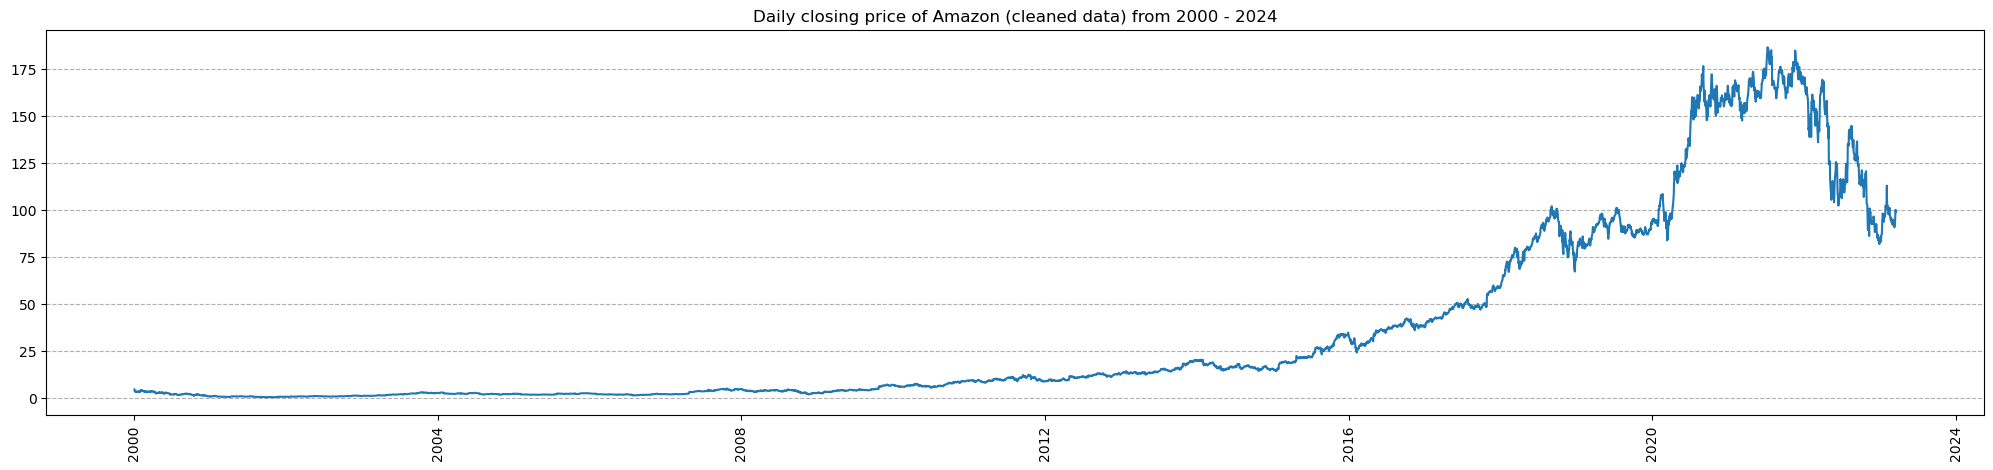

In [230]:
# a quick plot to view the data
fig = plt.figure(figsize=(25,5))
plt.plot(cDataAmazon.index, cDataAmazon['Close'])
plt.xticks(rotation='vertical')
plt.title('Daily closing price of Amazon (cleaned data) from 2000 - 2024')
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

In [231]:
# rescale the close price to have it between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
rescaledCloses = scaler.fit_transform(np.array(cDataAmazon)).reshape(-1,1)

# make a new column in cDataAmazon for rescaled Closes
cDataAmazon['ReClose'] = rescaledCloses.copy()

cDataAmazon

/var/folders/y2/1tq7nb7j4wzb95l1hpfl1p3r0000gn/T/ipykernel_19105/2679055326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cDataAmazon['ReClose'] = rescaledCloses.copy()


,Close,ReClose
date,,
2000-01-03,4.468750,0.022388
2000-01-04,4.096875,0.020392
2000-01-05,3.487500,0.017120
2000-01-06,3.278125,0.015996
2000-01-07,3.478125,0.017070
...,...,...
2023-03-13,92.430000,0.494607
2023-03-14,94.879997,0.507760
2023-03-15,96.199997,0.514847


In [232]:
# copy the data without the original close price 
dataAmazon = cDataAmazon
del dataAmazon['Close']
dataAmazon

,ReClose
date,
2000-01-03,0.022388
2000-01-04,0.020392
2000-01-05,0.017120
2000-01-06,0.015996
2000-01-07,0.017070
...,...
2023-03-13,0.494607
2023-03-14,0.507760
2023-03-15,0.514847


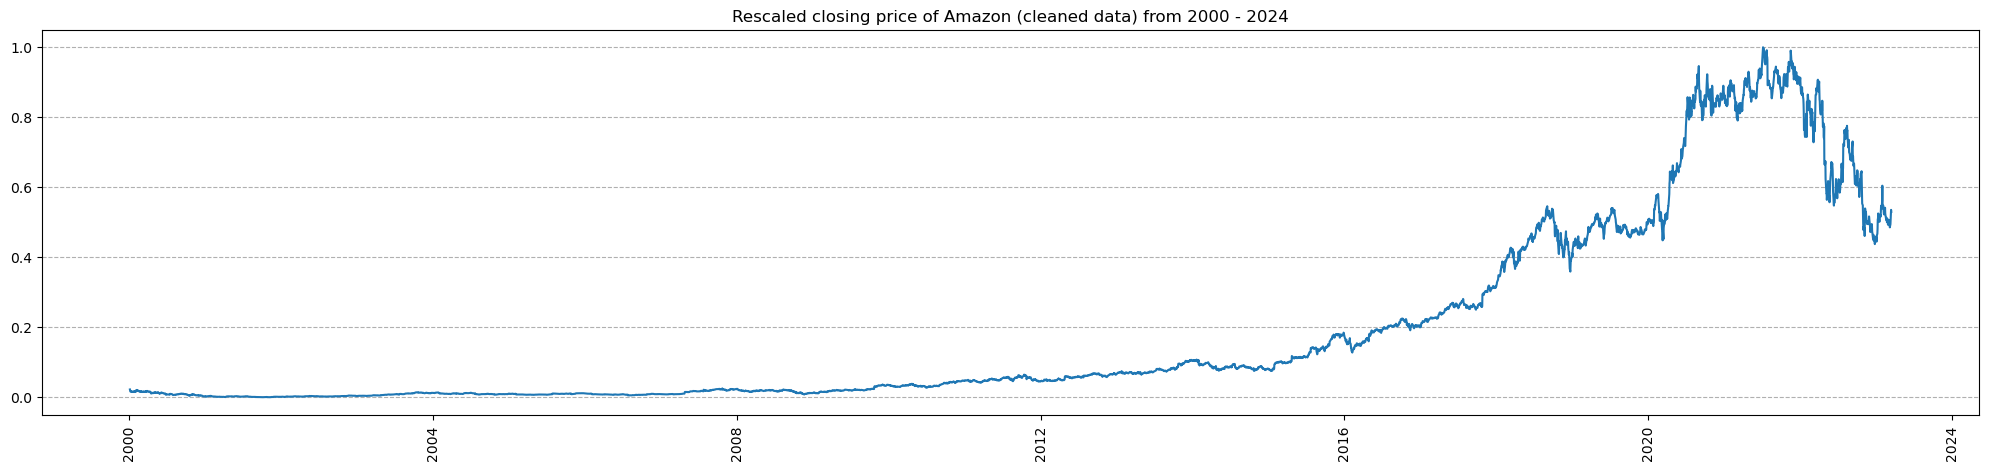

In [233]:
fig = plt.figure(figsize=(25,5))
plt.plot(cDataAmazon.index, rescaledCloses)
plt.xticks(rotation='vertical')
plt.title('Rescaled closing price of Amazon (cleaned data) from 2000 - 2024')
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

In [234]:
# split the data into training and testing sets


In [235]:
def generate_window_dataframe(dataframe, start_date_str, end_date_str, n=5):
    """
    Generate a windowed DataFrame containing historical closing prices and target closing prices.
    
    Args:
        dataframe (pd.DataFrame): The input DataFrame with a 'Close' column and datetime index.
        start_date_str (str): The start date in the format 'YYYY-MM-DD'.
        end_date_str (str): The end date in the format 'YYYY-MM-DD'.
        n (int, optional): The window size. Default is 5.
    
    Returns:
        pd.DataFrame: A DataFrame containing the target dates, windowed closing prices, 
                      and the actual closing price on the target date.
                      
    Raises:
        Exception: If the window size is too large for the data available for a given target date.
    """
    # Convert start and end date strings to datetime objects
    start_date = convert_to_datetime(start_date_str)
    end_date = convert_to_datetime(end_date_str)
    
    target_date = start_date
    dates, X, Y = [], [], []

    while target_date <= end_date:
        # Get the subset of data up to the target date and take the last n+1 entries
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            raise Exception(f'Error: Window of size {n} is too large.')

        # Extract the closing prices
        values = df_subset['ReClose'].to_numpy()
        x, y = values[:-1], values[-1]

        # Append the date and the windowed data
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Move to the next date
        next_dates = dataframe.loc[target_date:].index[1:2]
        if not len(next_dates):
            break
        target_date = next_dates[0]

    # Create the resulting DataFrame
    ret_df = pd.DataFrame({'Target Date': dates})

    X = np.array(X)
    for i in range(n):
        ret_df[f'F-{n-i}'] = X[:, i]

    ret_df['Output'] = Y

    return ret_df

In [236]:
# use the windowing for all data and use the windowing for the last 5 years 
# skip the first couple days from the df so that window is not affected 
windfAll = generate_window_dataframe(dataAmazon, 
                                        '2000-01-11', 
                                        '2023-03-17',
                                        n = 6)
                                     
windfAll

,Target Date,F-6,F-5,F-4,F-3,F-2,F-1,Output
0,2000-01-11,0.022388,0.020392,0.017120,0.015996,0.017070,0.016969,0.016315
1,2000-01-12,0.020392,0.017120,0.015996,0.017070,0.016969,0.016315,0.015459
2,2000-01-13,0.017120,0.015996,0.017070,0.016969,0.016315,0.015459,0.016097
3,2000-01-14,0.015996,0.017070,0.016969,0.016315,0.015459,0.016097,0.015644
4,2000-01-18,0.017070,0.016969,0.016315,0.015459,0.016097,0.015644,0.015610
...,...,...,...,...,...,...,...,...
5828,2023-03-13,0.507868,0.501694,0.500620,0.502606,0.493641,0.485481,0.494607
5829,2023-03-14,0.501694,0.500620,0.502606,0.493641,0.485481,0.494607,0.507760
5830,2023-03-15,0.500620,0.502606,0.493641,0.485481,0.494607,0.507760,0.514847
5831,2023-03-16,0.502606,0.493641,0.485481,0.494607,0.507760,0.514847,0.535462


In [237]:
windf5 = generate_window_dataframe(dataAmazon, 
                                        '2017-03-17', 
                                        '2023-03-17',
                                        n = 6)
windf5

,Target Date,F-6,F-5,F-4,F-3,F-2,F-1,Output
0,2017-03-17,0.227364,0.227219,0.227791,0.227238,0.227356,0.227476,0.227179
1,2017-03-20,0.227219,0.227791,0.227238,0.227356,0.227476,0.227179,0.228429
2,2017-03-21,0.227791,0.227238,0.227356,0.227476,0.227179,0.228429,0.224733
3,2017-03-22,0.227238,0.227356,0.227476,0.227179,0.228429,0.224733,0.226038
4,2017-03-23,0.227356,0.227476,0.227179,0.228429,0.224733,0.226038,0.225855
...,...,...,...,...,...,...,...,...
1506,2023-03-13,0.507868,0.501694,0.500620,0.502606,0.493641,0.485481,0.494607
1507,2023-03-14,0.501694,0.500620,0.502606,0.493641,0.485481,0.494607,0.507760
1508,2023-03-15,0.500620,0.502606,0.493641,0.485481,0.494607,0.507760,0.514847
1509,2023-03-16,0.502606,0.493641,0.485481,0.494607,0.507760,0.514847,0.535462


In [242]:
# method to split a given df into train, val, and test splits 
def make_splits(df, train_perc=70, val_perc=20, test_perc=10):
    if train_perc + val_perc + test_perc != 100:
        raise ValueError("Percentages must sum up to 100")

    # Calculate the number of rows for each split
    n = len(df)
    train_end = int(train_perc / 100 * n)
    val_end = train_end + int(val_perc / 100 * n)

    # extract the output and dates 
    dates = df['Target Date'].copy()
    outputs = df['Output'].copy()

    df = df.drop(columns=['Target Date', 'Output'])
    
    # Split the DataFrame
    train_x = df.iloc[:train_end]
    train_y = outputs.iloc[:train_end]
    dates_train = dates.iloc[:train_end]
    
    val_x = df.iloc[train_end:val_end]
    val_y = outputs.iloc[train_end:val_end]
    dates_val = dates.iloc[train_end:val_end]
    
    test_x = df.iloc[val_end:]
    test_y = outputs.iloc[val_end:]
    dates_test = dates.iloc[val_end:]

    return train_x, train_y, dates_train, val_x, val_y, dates_val, test_x, test_y, dates_test

In [243]:
train_x, train_y, dates_train, val_x, val_y, dates_val, test_x, test_y, dates_test= make_splits(windf5)

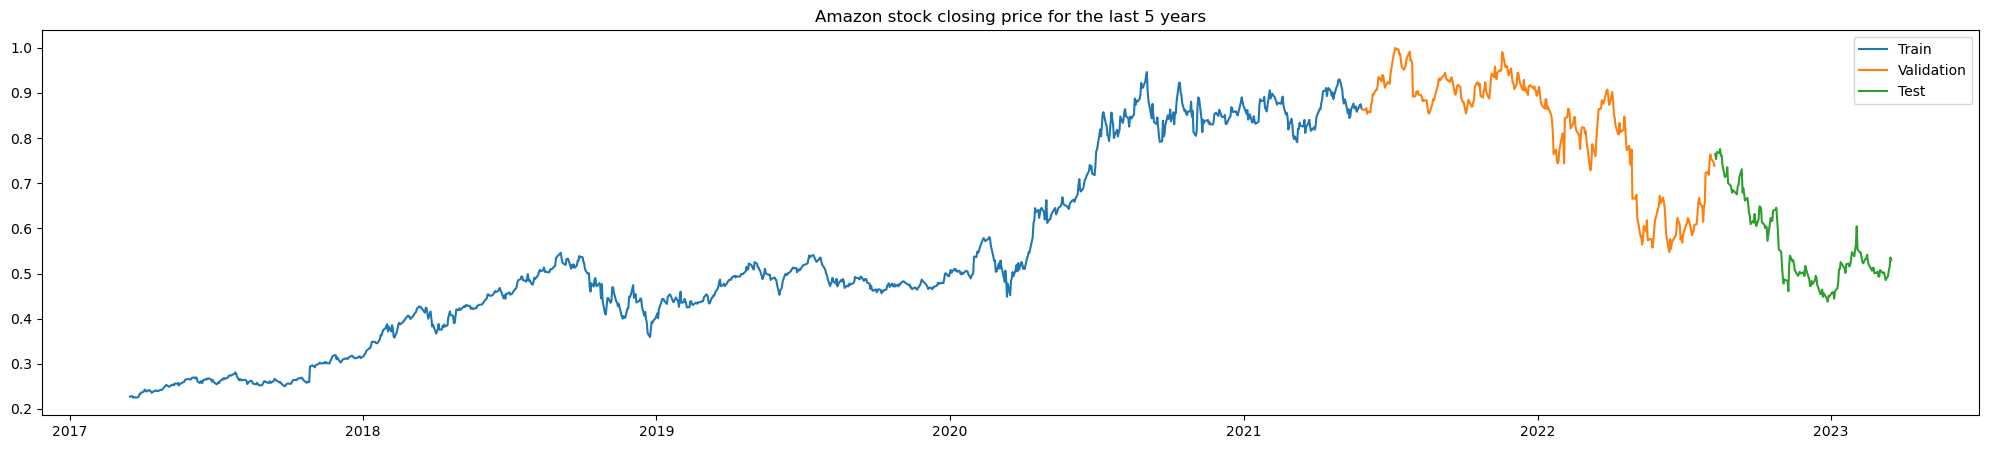

In [244]:
fig = plt.figure(figsize=(25,5))

plt.plot(dates_train, train_y)
plt.plot(dates_val, val_y)
plt.plot(dates_test, test_y)

plt.title('Amazon stock closing price for the last 5 years')
plt.legend(['Train', 'Validation', 'Test'])

In [246]:
# viewing the shape of each array
print(np.array(train_x).shape, np.array(val_x).shape, np.array(test_x).shape)
print(np.array(train_y).shape, np.array(val_y).shape, np.array(test_y).shape)

(1057, 6) (302, 6) (152, 6)
(1057,) (302,) (152,)
